In [1]:
#from libs.prefect_helpers import *
from libs.data_manipulation import *
from libs.feature_generation import *
from libs.dim_reduction import *
from libs.football_plots import *
from libs.clustering import *
from libs.convex_hull import *

import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

from mplsoccer import *
import pandas as pd
import numpy as np
import os
# Click player into the pitch and take those player and apply Ripleys K to them. And then maybe PCA


In [2]:
# Step 6: Extract match data from tracking data
data = compile_team_tracking_data("data/H_EURO2020", "DEN")
print(data.head())
one_match = extract_one_match(data, 1)
ripley_k_whole_match = ripley_k_by_indices(one_match, one_match.iloc[::48].index)


   frame_team  Time [s]_team half_team  home_1_x  home_1_y  home_3_x  \
0           0           0.00        1H     52.49     -0.08     19.96   
1           1           0.04        1H     52.51     -0.06     19.95   
2           2           0.08        1H     52.53     -0.05     19.95   
3           3           0.12        1H     52.51     -0.06     19.94   
4           4           0.16        1H     52.51     -0.05     19.94   

   home_3_y  home_4_x  home_4_y  home_5_x  ...  away_19_y  away_22_x  \
0      0.13     21.84     10.54     18.66  ...        NaN      -0.41   
1      0.14     21.87     10.56     18.68  ...        NaN      -0.40   
2      0.15     21.89     10.57     18.70  ...        NaN      -0.34   
3      0.16     21.90     10.58     18.73  ...        NaN      -0.29   
4      0.17     21.92     10.59     18.76  ...        NaN      -0.23   

   away_22_y  away_23_x  away_23_y  away_26_x  away_26_y  ball_x  ball_y  \
0      28.75      -0.43      33.28        NaN        NaN  

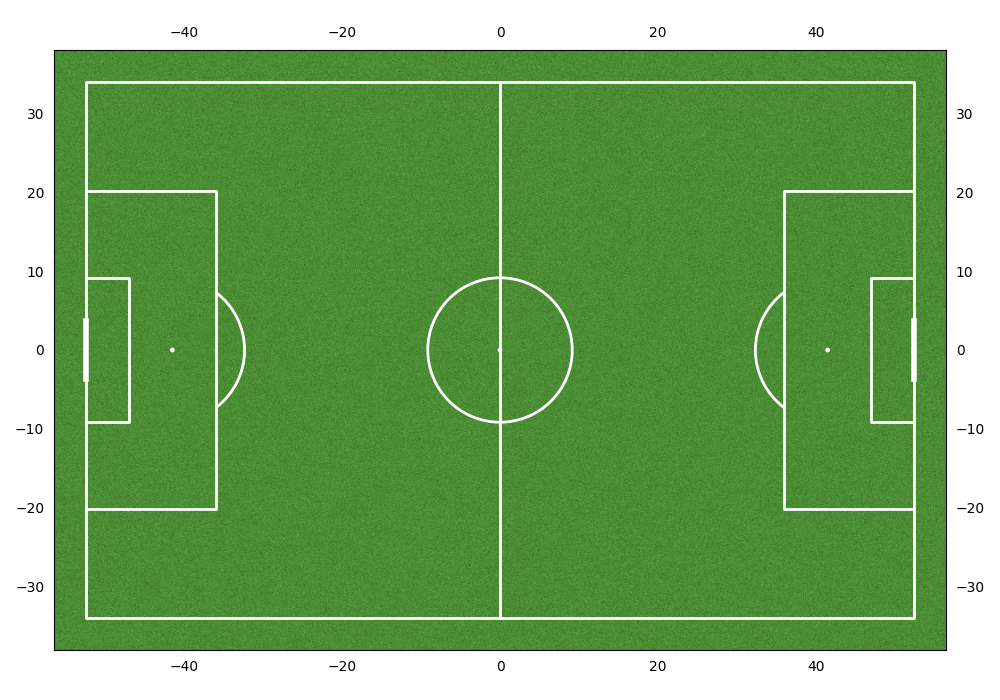

Ball placement mode enabled. Click to place the ball on the pitch.
Ball placed at: (np.float64(14.7178370458452), np.float64(1.7479385694097687))
Ball placed at: (np.float64(25.483896776335655), np.float64(17.200400770819584))
Ball placement mode disabled.
Cleared the current situation. All players are available for selection again.
Cleared the current situation. All players are available for selection again.
Ball placement mode enabled. Click to place the ball on the pitch.
Ball placed at: (np.float64(-0.10132752435929149), np.float64(0.35468378075805873))
Situation saved! Total saved situations: 1


In [28]:
%matplotlib widget

import matplotlib.pyplot as plt
from mplsoccer import Pitch 
import ipywidgets as widgets
import numpy as np
from IPython.display import display

# Initialize plot
football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
fig, ax = football_pitch.draw(figsize=(10, 7))

# List to store points for the current situation, vectors, and ball position
players = []
points = []
vectors = []
situations = []
ball_position = None  # Variable to store ball position

# Booleans to check modes
draw_vector_mode = False
place_ball_mode = False
vector_start = None  # To store the start point of the vector

# Function to handle mouse clicks for points, vectors, and ball
def on_click(event):
    global vector_start, draw_vector_mode, place_ball_mode, ball_position
    
    if event.inaxes:  # Check if click is inside plot
        x, y = event.xdata, event.ydata  # Get coordinates
        
        if place_ball_mode:
            # Place the ball at the clicked position
            ball_position = (x, y)
            ax.plot(x, y, 'o', color='green', markersize=10, label="Ball" if not any(artist.get_label() == "Ball" for artist in ax.get_children()) else "")
            plt.draw()  # Update the plot
            print(f"Ball placed at: {ball_position}")

        elif draw_vector_mode:
            if vector_start is None:  # If no start point, set this as start point
                vector_start = (x, y)
                ax.plot(x, y, 'bo')  # Mark the start point with a blue dot
            else:
                # If there's already a start point, draw the vector from start to this point
                vector_end = (x, y)
                ax.annotate('', xy=vector_end, xytext=vector_start,
                            arrowprops=dict(facecolor='red', shrink=0.05))  # Draw vector
                vectors.append((vector_start, vector_end))  # Save the vector
                vector_start = None  # Reset the start point
        else:
            points.append((x, y))  # Add to list of points
            ax.plot(x, y, 'ro')  # Plot the point

# Function to save the current situation
def save_situation(_):
    if points or vectors or ball_position:
        situations.append({'points': list(points), 'vectors': list(vectors), 'ball': ball_position})  # Save the current points, vectors, and ball position
        print(f"Situation saved! Total saved situations: {len(situations)}")
    else:
        print("No players, vectors, or ball to save!")

# Function to clear the current situation and reset player lists
def clear_situation(_):
    global points, vectors, vector_start, players, home_player_numbers, away_player_numbers, ball_position
    
    points = []  # Clear the current points
    vectors = []  # Clear the current vectors
    players = []  # Clear the list of selected players
    vector_start = None  # Reset vector start point
    ball_position = None  # Reset ball position
    
    # Reset player lists and dropdown options using the backup lists
    home_player_numbers = backup_home_player_numbers.copy()
    away_player_numbers = backup_away_player_numbers.copy()
    
    home_players_dropdown.options = [("Select Player", "")] + [(f"{player}", player) for player in home_player_numbers]
    away_players_dropdown.options = [("Select Player", "")] + [(f"{player}", player) for player in away_player_numbers]
    
    ax.cla()  # Clear the plot
    football_pitch.draw(ax=ax)  # Redraw the empty pitch
    plt.draw()
    print("Cleared the current situation. All players are available for selection again.")

# Function to toggle vector drawing mode
def toggle_draw_vector(_):
    global draw_vector_mode, place_ball_mode
    draw_vector_mode = not draw_vector_mode  # Toggle the mode
    place_ball_mode = False  # Disable ball placement if entering vector mode
    if draw_vector_mode:
        print("Vector drawing mode enabled. Select start and end points for the vector.")
    else:
        print("Switched to player drawing mode.")

# Function to toggle ball placement mode
def toggle_place_ball(_):
    global place_ball_mode, draw_vector_mode
    place_ball_mode = not place_ball_mode  # Toggle ball placement mode
    draw_vector_mode = False  # Disable vector mode if entering ball mode
    if place_ball_mode:
        print("Ball placement mode enabled. Click to place the ball on the pitch.")
    else:
        print("Ball placement mode disabled.")

def select_player(player_num, dropdown, player_list):
    players.append(player_num)
    print(players)
    
    # Remove the selected player from the dropdown options
    player_list.remove(player_num)
    updated_player_list = [(f"{player}", player) for player in player_list]
    dropdown.options = [("Select Player", "")] + updated_player_list

def remove_player(player_num, dropdown, player_list):
    try:
        players.remove(player_num)
        print(players)
        # Add the removed player back to the dropdown options
        player_list.append(player_num)
        player_list.sort()
        dropdown.options = [("Select Player", "")] + [(f"{player}", player) for player in player_list]
    except:
        print("Player not in list")

# Create save, clear, toggle vector, and toggle ball buttons
save_button = widgets.Button(description="Save Situation", button_style='success')
clear_button = widgets.Button(description="Clear", button_style='warning')
toggle_vector_button = widgets.Button(description="Toggle Draw Vector", button_style='info')
toggle_ball_button = widgets.Button(description="Place Ball", button_style='primary')

# Get unique home and away players using your regex logic
players_xy = one_match.filter(regex="^home").columns.to_numpy()  # Modify to match your dataframe
home_player_numbers = list(np.unique([player[:-1] for player in players_xy]))  # Convert to a list for mutation
backup_home_player_numbers = home_player_numbers.copy()  # Keep a backup of the original list

away_players_xy = one_match.filter(regex="^away").columns.to_numpy()  # Modify to match your dataframe
away_player_numbers = list(np.unique([player[:-1] for player in away_players_xy]))  # Convert to a list for mutation
backup_away_player_numbers = away_player_numbers.copy()  # Keep a backup of the original list

# Create dropdowns for home and away players
home_players_dropdown = widgets.Dropdown(
    options=[("Select Player", "")] + [(f"{player}", player) for player in home_player_numbers],  # Add "Select Player"
    description='Home Player:',
    disabled=False,
)

away_players_dropdown = widgets.Dropdown(
    options=[("Select Player", "")] + [(f"{player}", player) for player in away_player_numbers],  # Add "Select Player"
    description='Away Player:',
    disabled=False,
)

# Functions for adding/removing players from the dropdowns
def home_player_selected(change):
    selected_player = change['new']
    if selected_player:  # Only proceed if a valid player is selected
        select_player(selected_player, home_players_dropdown, home_player_numbers)

def away_player_selected(change):
    selected_player = change['new']
    if selected_player:  # Only proceed if a valid player is selected
        select_player(selected_player, away_players_dropdown, away_player_numbers)

# Observe changes in dropdown selection
home_players_dropdown.observe(home_player_selected, names='value')
away_players_dropdown.observe(away_player_selected, names='value')

# Connect button click events to their functions
save_button.on_click(save_situation)
clear_button.on_click(clear_situation)
toggle_vector_button.on_click(toggle_draw_vector)
toggle_ball_button.on_click(toggle_place_ball)

# Create layout for the UI elements
ui_layout = widgets.HBox([widgets.VBox([home_players_dropdown, away_players_dropdown]), 
                          widgets.VBox([save_button, clear_button, toggle_vector_button, toggle_ball_button])])

# Connect the click event to the handler
fig.canvas.mpl_connect('button_press_event', on_click)

# Display the UI layout and plot
display(ui_layout)


In [29]:
regex = ""
for player in players:
    regex += "^"+player + "|" 
regex = regex[:-1]


#one_match = one_match.filter(regex = regex)
print(one_match.columns)

Index(['Time [s]', 'frame_team', 'Time [s]_team', 'half_team', 'home_1_x',
       'home_1_y', 'home_3_x', 'home_3_y', 'home_4_x', 'home_4_y', 'home_5_x',
       'home_5_y', 'home_6_x', 'home_6_y', 'home_8_x', 'home_8_y', 'home_9_x',
       'home_9_y', 'home_14_x', 'home_14_y', 'home_18_x', 'home_18_y',
       'home_20_x', 'home_20_y', 'home_23_x', 'home_23_y', 'ball_x_team',
       'ball_y_team', 'Period_team', 'frame', 'half', 'away_2_x', 'away_2_y',
       'away_3_x', 'away_3_y', 'away_7_x', 'away_7_y', 'away_11_x',
       'away_11_y', 'away_13_x', 'away_13_y', 'away_14_x', 'away_14_y',
       'away_15_x', 'away_15_y', 'away_16_x', 'away_16_y', 'away_17_x',
       'away_17_y', 'away_22_x', 'away_22_y', 'away_23_x', 'away_23_y',
       'ball_x', 'ball_y', 'Period'],
      dtype='object')


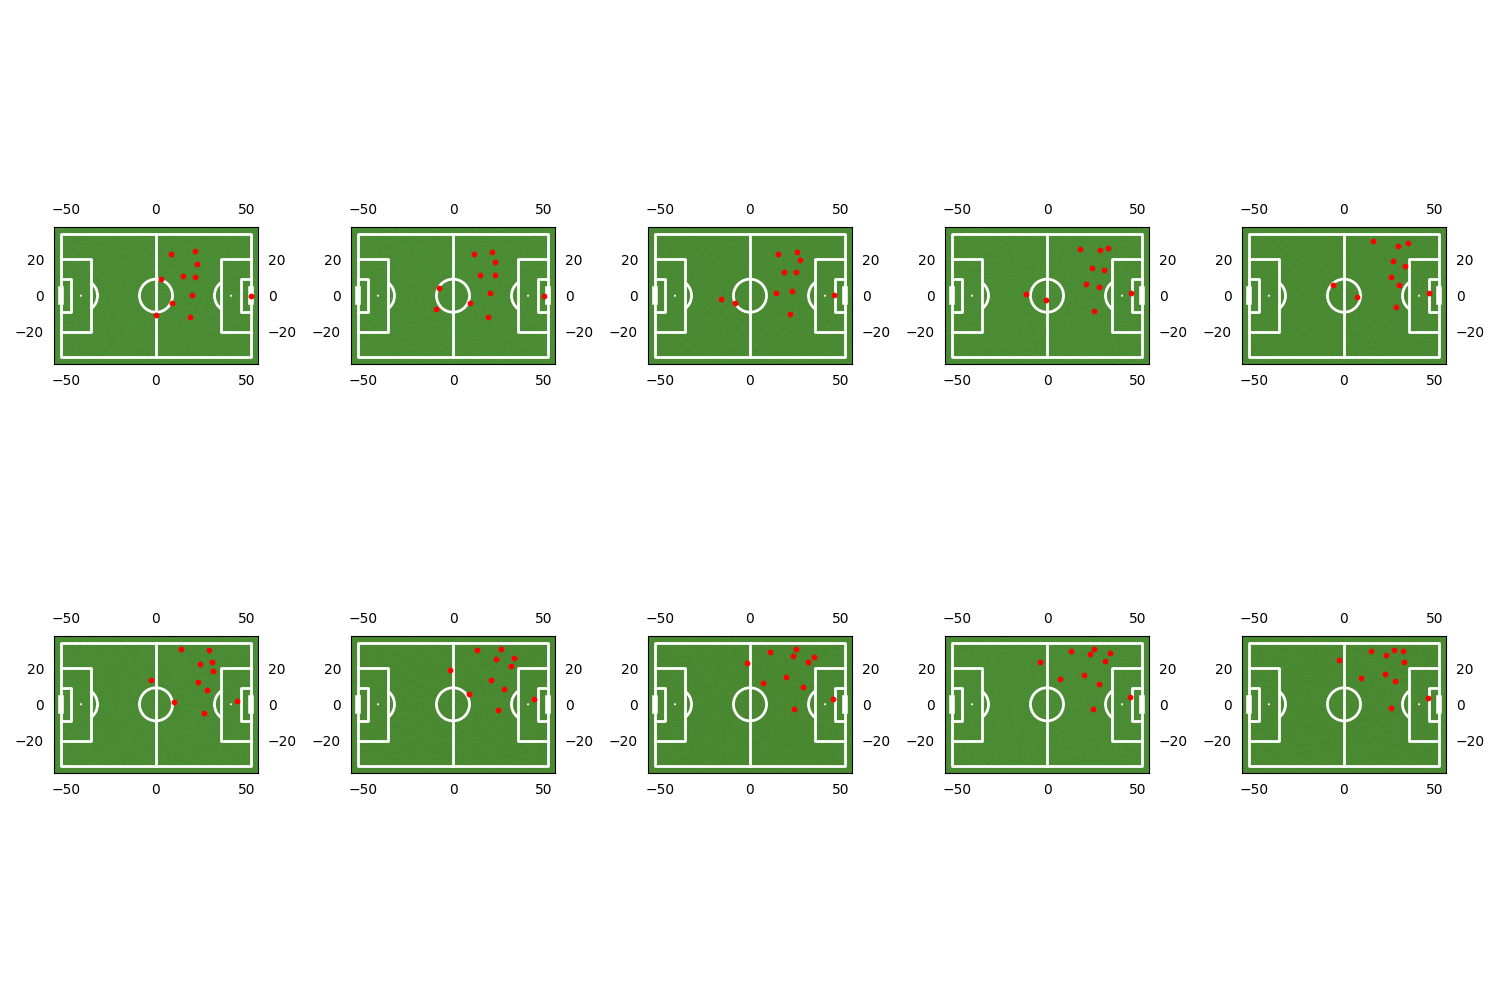

In [5]:

from libs.alpha_shape import *

alpha = 0.3

alpha_shapes, indices = alpha_shape(one_match.iloc[::48],alpha=alpha)

chosen_alpha_shape = alphashape.alphashape(points, alpha=alpha)
chosen_alpha_shape = normalize_geometry(chosen_alpha_shape)

top_100_alpha_shapes = top_n_similar_geometries(chosen_alpha_shape, alpha_shapes, indices, 100)


relevant_situations = np.array(top_100_alpha_shapes)[:,1]

fig, ax = plt.subplots(2, 5, figsize=(15, 10))

data = one_match.filter(regex = "^home")

# Create the pitch with the desired settings
for hull, i in zip(top_100_alpha_shapes[:10], range(len(top_100_alpha_shapes[:10]))):
    row = i // 5  # Determine the row index
    col = i % 5   # Determine the column index
    
    # Create a new pitch on each subplot
    football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, 
                           label=True, line_color="white", pitch_color="grass")
    football_pitch.draw(ax=ax[row, col])  # Draw the pitch on the current axis
    
    point_pairs = data.loc[hull[1]].to_numpy()

    points_current = np.array([np.array(list(pair)) for pair in zip(point_pairs[:-1:2], point_pairs[1::2])])


    # Scatter plot for convex hull points
    ax[row, col].scatter(points_current[:, 0], points_current[:, 1], color='red', s=10)

plt.tight_layout()
plt.show()

In [6]:
from libs.convex_hull import *

hulls, indices = convex_hull(one_match.iloc[::48])

chosen_hull = ConvexHull(points)
chosen_hull = normalize_hull(chosen_hull)

top_100_hulls = top_n_similar_hulls(chosen_hull, hulls,indices,100)

relevant_situations = np.array(top_100_hulls)[:,1]

fig, ax = plt.subplots(2, 5, figsize=(15, 10))

# Create the pitch with the desired settings
for hull, i in zip(top_100_hulls[:10], range(len(top_100_hulls[:10]))):
    row = i // 5  # Determine the row index
    col = i % 5   # Determine the column index
    print(hull[1])
    # Create a new pitch on each subplot
    football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, 
                           label=True, line_color="white", pitch_color="grass")
    football_pitch.draw(ax=ax[row, col])  # Draw the pitch on the current axis
    
    # Scatter plot for convex hull points
    ax[row, col].scatter(hull[0].points[:, 0], hull[0].points[:, 1], color='red', s=10)

plt.tight_layout()
plt.show()
radii = np.arange(0, 34)

points_array = np.array(points)
points_series = pd.Series(points_array.flatten())


68928
31872
49872
19728
28512
49824
2784
2736
40224
2688


Collected 11 points.
0     40.936359
1     -0.152016
2     30.296959
3    -12.817969
4     30.423618
5     -1.671930
6     29.410342
7     11.247341
8     18.137644
9     26.446484
10    19.404240
11     6.307620
12    19.657559
13    -7.624928
14    20.290856
15   -19.530924
16     9.018158
17   -13.197947
18     8.638180
19     0.607941
20     7.751563
21    14.287170
dtype: float64


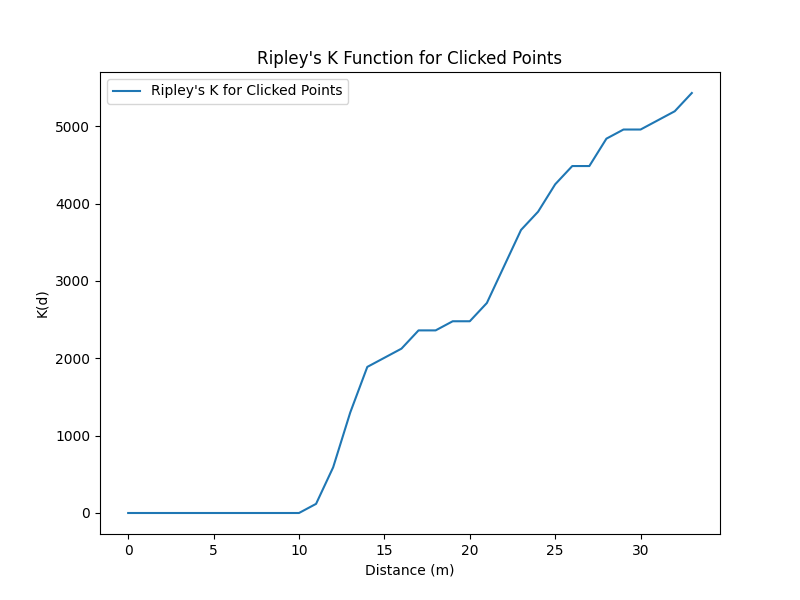

In [7]:
# Ensure the interactive pitch has captured points
if not points:
    print("Please click on the pitch to add points.")
else:
    print(f"Collected {len(points)} points.")

# Step 2: Convert the points from the interactive pitch into a usable format
points_array = np.array(points)  # Convert the collected points into a NumPy array

if points_array.shape[0] > 1:
    # Flatten the points for Ripley's K
    points_series = pd.Series(points_array.flatten())
    print(points_series)

    # Step 3: Define the radii for Ripley's K
    radii = np.arange(0, 34)  # Adjust the range based on your use case

    # Step 4: Calculate Ripley's K for the clicked points
    k_values_clicked = ripley_k(points_series, radii, width=105.0, height=68.0)

    # Step 5: Plot Ripley's K values for the clicked points
    plt.figure(figsize=(8, 6))
    plt.plot(radii, k_values_clicked, label="Ripley's K for Clicked Points")
    plt.xlabel('Distance (m)')
    plt.ylabel("K(d)")
    plt.title("Ripley's K Function for Clicked Points")
    plt.legend()
    plt.show()
else:
    print("Not enough points for Ripley's K calculation.")

here
here


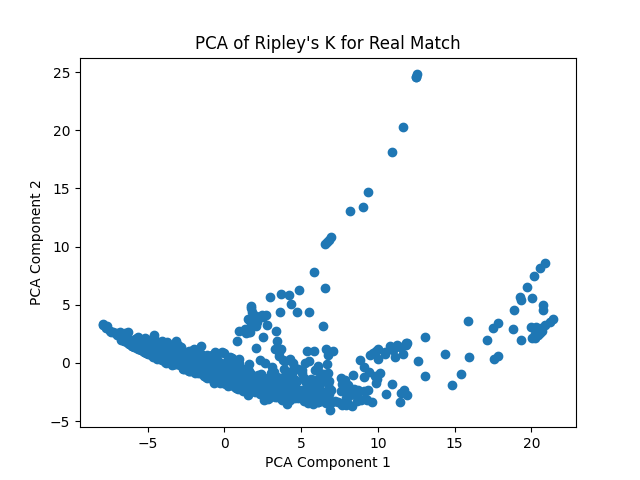

In [8]:
# Step 7: Calculate Ripley's K values for the real match data

ripley_k_vals_relevant = ripley_k_by_indices(one_match, relevant_situations)


#Added average position of team as feature

# Step 8: Perform PCA on the Ripley's K values from the real match data
pca_obj_ripley = PCAObject(ripley_k_whole_match, 10)  # Fit     PCA with 10 components
np_pca_ripley = pca_obj_ripley.transform(ripley_k_vals_relevant)
np_pca_ripley_full_match = pca_obj_ripley.transform(ripley_k_whole_match)

# Step 9: Plot the PCA-reduced Ripley's K values for the real match
plt.figure()
plt.scatter(np_pca_ripley_full_match[:, 0], np_pca_ripley_full_match[:, 1])
plt.title("PCA of Ripley's K for Real Match")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.savefig("pca_ripley.png")
plt.show()

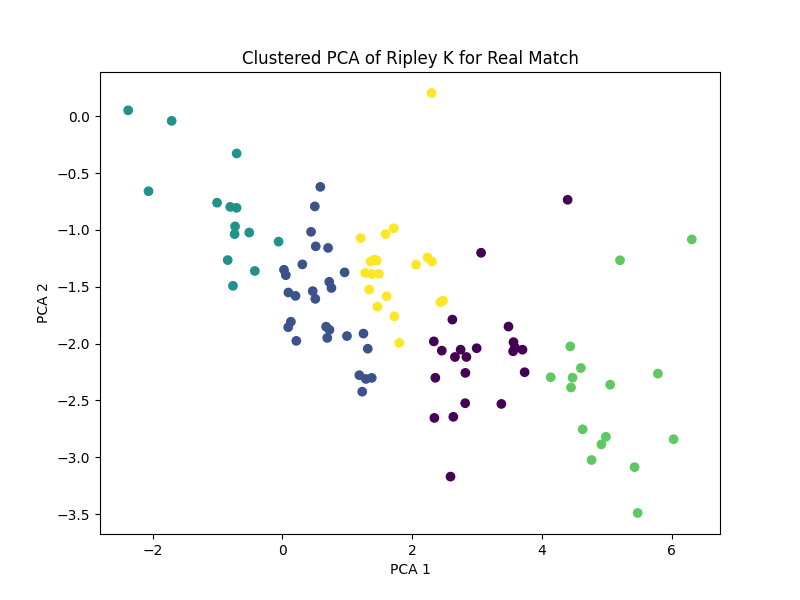

In [9]:
# Step 10: Cluster the PCA-reduced Ripley's K values using KMeans
clustering_obj_ripley = KMeansObject(np_pca_ripley, 5)  # Fit KMeans with 5 clusters
labels = clustering_obj_ripley.get_labels()

# Step 11: Plot the clustered PCA-reduced Ripley's K values
plt.figure(figsize=(8, 6))
plt.scatter(np_pca_ripley[:, 0], np_pca_ripley[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clustered PCA of Ripley K for Real Match')
plt.savefig("pca_ripley_clustered.png")
plt.show()

here


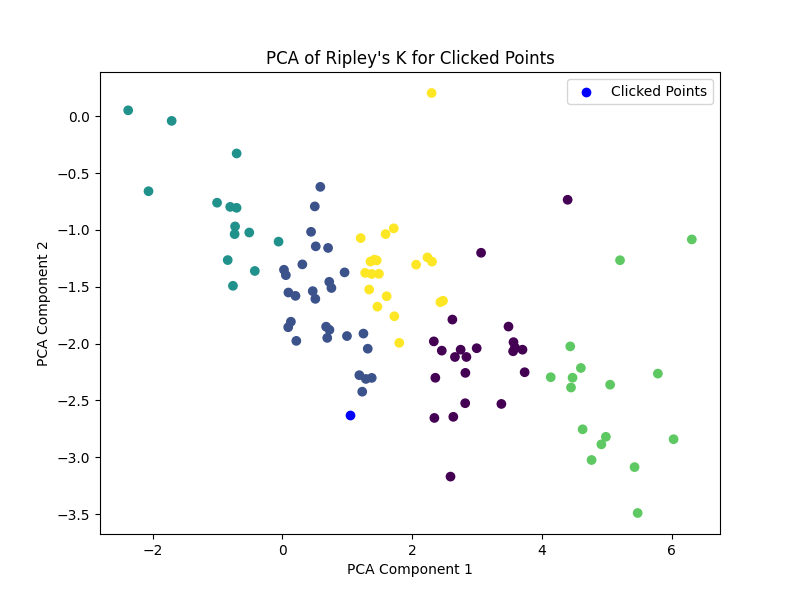

In [10]:
# Step 12: Apply PCA on the Ripley's K values for the clicked points
if points_array.shape[0] > 1:
    
    k_values_clicked_new = np.array(k_values_clicked).reshape(1, -1)  # Reshape for PCA compatibility
   



    
  
    reduced_k_values_clicked = pca_obj_ripley.transform(k_values_clicked_new)  # Transform using the same PCA model

    # Step 13: Plot the PCA-reduced clicked points

    plt.scatter(reduced_k_values_clicked[:, 0], reduced_k_values_clicked[:, 1], c='blue', label='Clicked Points')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title("PCA of Ripley's K for Clicked Points")
    plt.legend()
    plt.show()
else:
    print("Not enough points for Ripley's K calculation.")

In [11]:
from sklearn.neighbors import KDTree

# Step 1: Build a KDTree from the PCA-reduced real match data
tree = KDTree(np_pca_ripley)

# Step 2: Query the 10 nearest neighbors for the clicked situation
distances, indices = tree.query(reduced_k_values_clicked, k=10)  # Find 10 nearest neighbors

# Flatten the indices
closest_indices = indices.flatten()
print("Closest situation indices:", closest_indices)


Closest situation indices: [59 60 91 69 19 46 24 67 13 77]


In [12]:
# Assuming `one_match` is a DataFrame where each row contains player positions for a specific situation
# Each row of `one_match` contains the player positions in the format: [(x1, y1), (x2, y2), ...]

# Retrieve the 10 closest situations from the real match

closest_situations_indices = np.array(top_100_alpha_shapes)[closest_indices,1]

print(closest_situations_indices)
closest_situations = one_match.loc[closest_situations_indices]


[np.int64(2832) np.int64(2880) np.int64(4368) np.int64(3312) np.int64(912)
 np.int64(2208) np.int64(1152) np.int64(3216) np.int64(624) np.int64(3696)]


In [13]:
# Add time step columns to the closest situations. Each index is 24 time ticks
closest_situations

Time [s]  frame_team  Time [s]_team half_team  home_1_x  home_1_y  \
2832    113.28        2832         113.28        1H     45.94      0.05   
2880    115.20        2880         115.20        1H     43.42      0.03   
4368    174.72        4368         174.72        1H     52.55      3.92   
3312    132.48        3312         132.48        1H     40.16     -7.71   
912      36.48         912          36.48        1H     44.39     -0.22   
2208     88.32        2208          88.32        1H     49.38     -5.42   
1152     46.08        1152          46.08        1H     39.67      0.13   
3216    128.64        3216         128.64        1H     38.93     -4.25   
624      24.96         624          24.96        1H     47.51      2.49   
3696    147.84        3696         147.84        1H     34.63      0.79   

      home_3_x  home_3_y  home_4_x  home_4_y  ...  away_16_y  away_17_x  \
2832     21.28     -8.92     21.18      0.22  ...       1.04      13.50   
2880     17.68     -8.45     19.44      1.49  ...       1.00      11.34   
4368     17.92      3.81      9.67     24.12  ...       7.34       7.88   
3312     14.53    -29.36     16.81    -13.89  ...      -4.14       0.30   
912      31.58     -9.29     30.28      6.85  ...       1.52      11.33   
2208     37.43    -21.82     42.91     12.21  ...      -1.29      42.22   
1152      6.94     -0.48      8.99      5.72  ...       2.46     -17.22   
3216     14.41    -27.71     15.52    -11.14  ...      -4.26       4.70   
624      30.86      9.78     32.87     23.51  ...      11.63      30.08   
3696      0.58     -5.68      5.77     10.18  ...       1.72     -14.41   

      away_17_y  away_22_x  away_22_y  away_23_x  away_23_y  ball_x  ball_y  \
2832       5.51      20.59     -15.18      -2.51       6.78    2.56    5.96   
2880      10.82      17.63     -11.47      -9.70      10.72  -11.94    5.38   
4368      21.32       1.88       6.03      -4.38      28.95   16.61   17.31   
3312      -5.40      -2.02     -14.32     -11.21       6.56    0.32  -32.80   
912       11.28      16.04       8.81       7.03      19.95   31.51   -9.22   
2208      -5.35      23.31       1.85      18.36      18.01   38.42  -21.82   
1152      26.44      -3.50      11.88     -33.81      21.53  -26.46   34.75   
3216      -5.70       6.25     -15.44      -3.84      13.05    0.40  -30.50   
624       28.49      24.43      29.89      20.66      29.64   20.86   31.51   
3696      31.00      -0.65      16.02     -23.62      32.37  -13.31   31.57   

      Period  
2832       1  
2880       1  
4368       1  
3312       1  
912        1  
2208       1  
1152       1  
3216       1  
624        1  
3696       1  

[10 rows x 56 columns]

      Time [s]  frame_team  Time [s]_team half_team  home_1_x  home_1_y  \
2832    113.28        2832         113.28        1H     45.94      0.05   
2880    115.20        2880         115.20        1H     43.42      0.03   
4368    174.72        4368         174.72        1H     52.55      3.92   
3312    132.48        3312         132.48        1H     40.16     -7.71   
912      36.48         912          36.48        1H     44.39     -0.22   
2208     88.32        2208          88.32        1H     49.38     -5.42   
1152     46.08        1152          46.08        1H     39.67      0.13   
3216    128.64        3216         128.64        1H     38.93     -4.25   
624      24.96         624          24.96        1H     47.51      2.49   
3696    147.84        3696         147.84        1H     34.63      0.79   

      home_3_x  home_3_y  home_4_x  home_4_y  ...  away_16_y  away_17_x  \
2832     21.28     -8.92     21.18      0.22  ...       1.04      13.50   
2880     17.68     -8.45

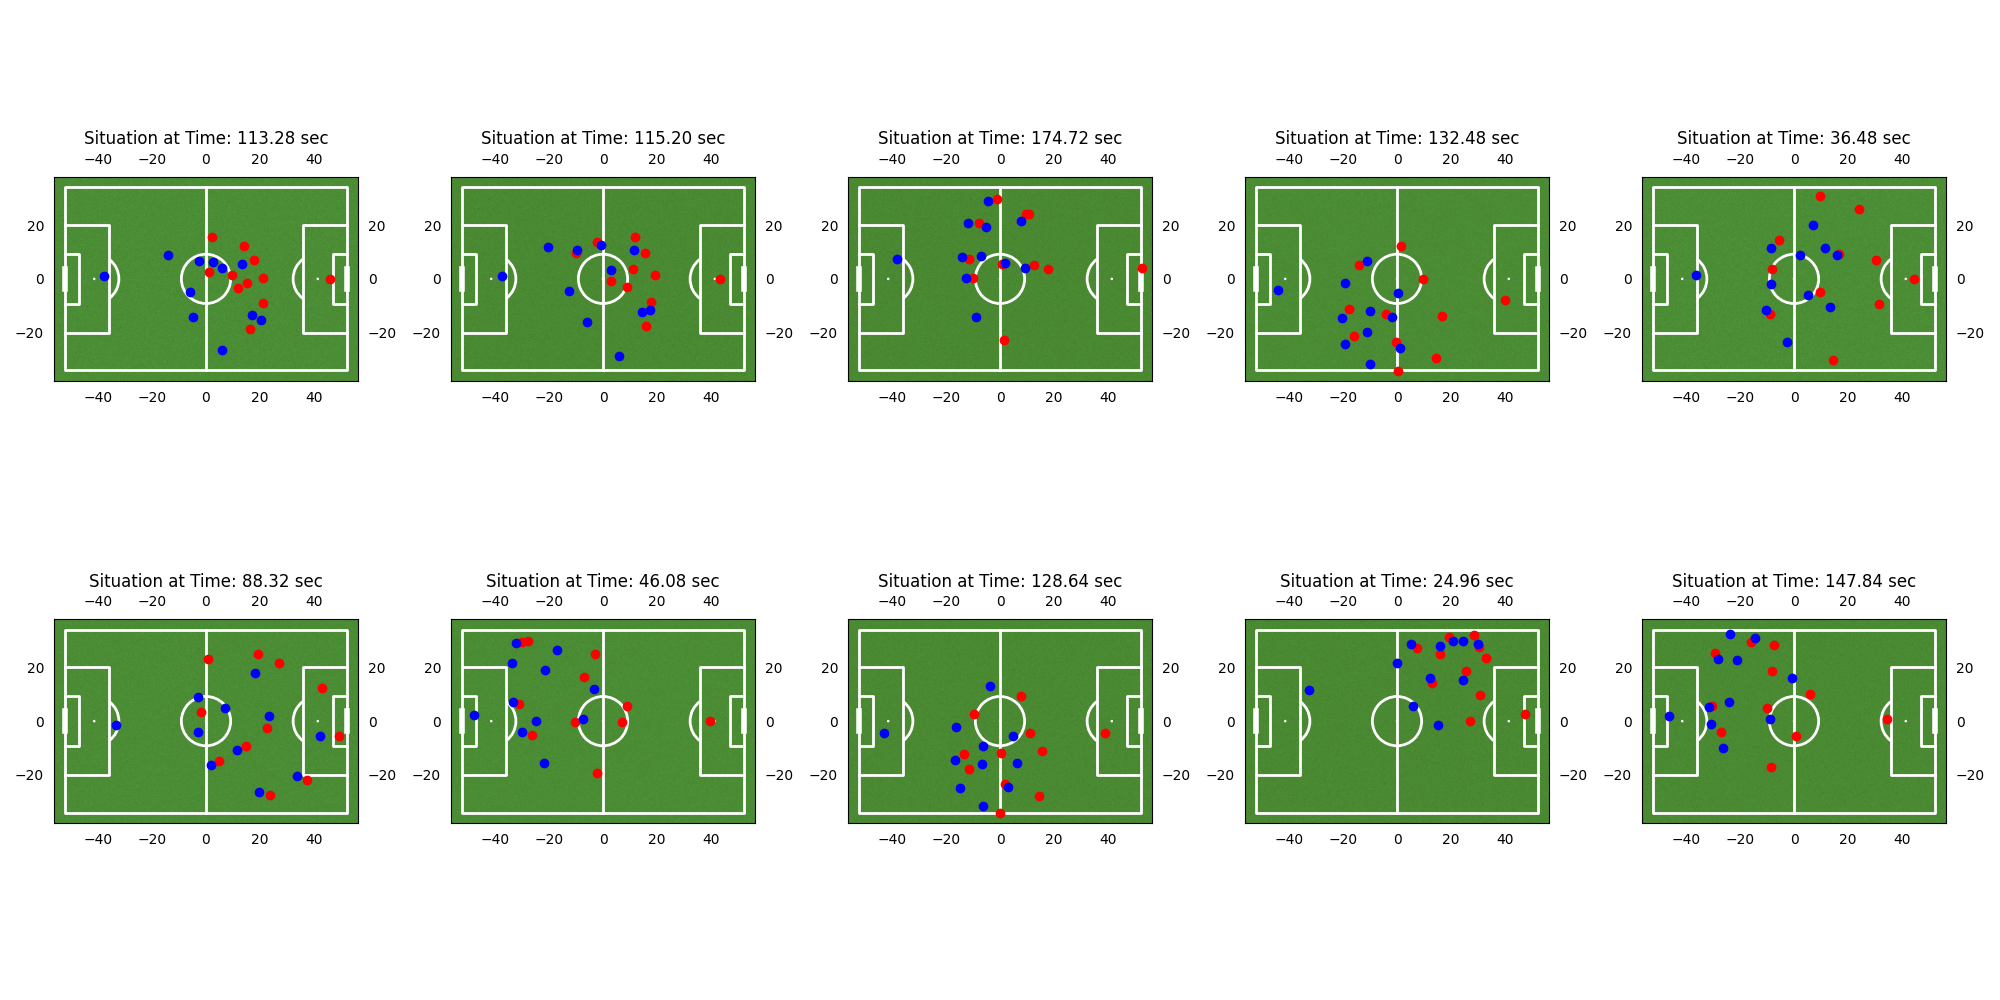

In [15]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import pandas as pd

# Function to extract player coordinates from the DataFrame
def extract_player_positions(row):
    # Extract home player positions (x and y)
    home_x_cols = [col for col in row.index if 'home' in col and '_x' in col]
    home_y_cols = [col for col in row.index if 'home' in col and '_y' in col]
    
    home_positions = [(row[x], row[y]) for x, y in zip(home_x_cols, home_y_cols) if not pd.isna(row[x]) and not pd.isna(row[y])]

    # Extract away player positions (x and y)
    away_x_cols = [col for col in row.index if 'away' in col and '_x' in col]
    away_y_cols = [col for col in row.index if 'away' in col and '_y' in col]
    
    away_positions = [(row[x], row[y]) for x, y in zip(away_x_cols, away_y_cols) if not pd.isna(row[x]) and not pd.isna(row[y])]

    return home_positions, away_positions

# Function to plot a single situation on the pitch
def plot_situation(row, ax):
    football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
    football_pitch.draw(ax=ax)
    
    # Extract player positions from the row
    home_positions, away_positions = extract_player_positions(row)
    
    # Plot home team players (red)
    for pos in home_positions:
        ax.plot(pos[0], pos[1], 'ro', label='Home Team')  # Mark home players as red dots


    # Plot away team players (blue)
    for pos in away_positions:
        ax.plot(pos[0], pos[1], 'bo', label='Away Team')  # Mark away players as blue dots
    
    ax.set_title(f"Situation at Time: {row['Time [s]']:.2f} sec")

# Step 4: Visualize the 10 closest situations on the pitch
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # Create a grid for 10 situations
axes = axes.flatten()
print(closest_situations)

# Make sure closest_situations contains all required columns from the original DataFrame
if 'Time [s]' in closest_situations.columns:
    for idx, situation_index in enumerate(closest_situations.index):  # Use the index of the closest situations
        plot_situation(closest_situations.loc[situation_index], axes[idx])  # Pass the row to plot_situation
else:
    print("Ensure that closest_situations contains full rows, including player position columns.")

plt.tight_layout()
plt.show()


In [38]:
from scipy.stats import wasserstein_distance

In [33]:
def calculate_weights_from_points(points, ball_position):
    """
    Calculate weights based on the proximity of each point in `points` to `ball_position`.
    The weights are normalized to sum to exactly 1.
    
    Parameters:
    points (np.ndarray): Array of player positions with shape (n, 2), where n is the number of players.
    ball_position (tuple): (x, y) position of the ball.
    
    Returns:
    np.ndarray: Array of normalized weights that sum to 1.
    """
    weights = []
    
    # Calculate the inverse distance to the ball for each point
    for player_position in points:
        distance_to_ball = np.sqrt((player_position[0] - ball_position[0])**2 + (player_position[1] - ball_position[1])**2)
        weight = 1 / (distance_to_ball + 1e-6)  # Inverse distance to ball
        weights.append(weight)
    
    # Convert weights to a numpy array
    weights = np.array(weights)
    
    # Normalize weights to sum to 1
    weights_sum = np.sum(weights)
    if weights_sum > 0:
        weights = weights / weights_sum  # Normalize
    
    # Adjust the last weight to ensure an exact sum of 1
    if weights.size > 0:
        weights[-1] += 1 - np.sum(weights)
    
    return weights

In [22]:
# Function to calculate weights based on proximity to the ball and ensure they sum to exactly 1
def calculate_weights(df: pd.DataFrame, ball_x_col='ball_x', ball_y_col='ball_y', regex="^home"):
    ball_x = df[ball_x_col].values
    ball_y = df[ball_y_col].values
    player_cols = df.filter(regex=regex).columns
    
    # Extract player positions and calculate inverse distance to the ball
    weights_list = []
    x_cols = [col for col in player_cols if col.endswith('_x')]
    y_cols = [col for col in player_cols if col.endswith('_y')]
    
    for frame_idx in range(len(df)):
        weights = []
        for i in range(len(x_cols)):  # Loop through all players
            player_x = df.loc[frame_idx, x_cols[i]]
            player_y = df.loc[frame_idx, y_cols[i]]
            
            # Check if player_x or player_y is NaN (inactive player)
            if np.isnan(player_x) or np.isnan(player_y):
                continue  # Skip this player if they are inactive
            
            # Calculate the distance to the ball
            distance_to_ball = np.sqrt((player_x - ball_x[frame_idx])**2 + (player_y - ball_y[frame_idx])**2)
            weight = 1 / (distance_to_ball + 1e-6)  # Inverse distance to the ball
            weights.append(weight)
        
        # Normalize weights to sum to 1
        weights = np.array(weights)
        weights_sum = np.sum(weights)
        if weights_sum > 0:
            weights = weights / weights_sum  # Normalize
        
        # Correct the last weight to ensure exact sum of 1
        if weights.size > 0:
            weights[-1] += 1 - np.sum(weights)
        
        weights_list.append(weights)
    
    return weights_list  # Return a list of arrays with normalized weights

Wasserstein distances to closest situations: [np.float64(16.227991045801957), np.float64(17.31881185135583), np.float64(11.518709355935536), np.float64(34.97169629483843), np.float64(11.484894503626554), np.float64(14.45644447203762), np.float64(21.614034681233704), np.float64(31.481530338514126), np.float64(8.730532189715744), np.float64(17.64074424426006)]


AttributeError: 'str' object has no attribute 'items'

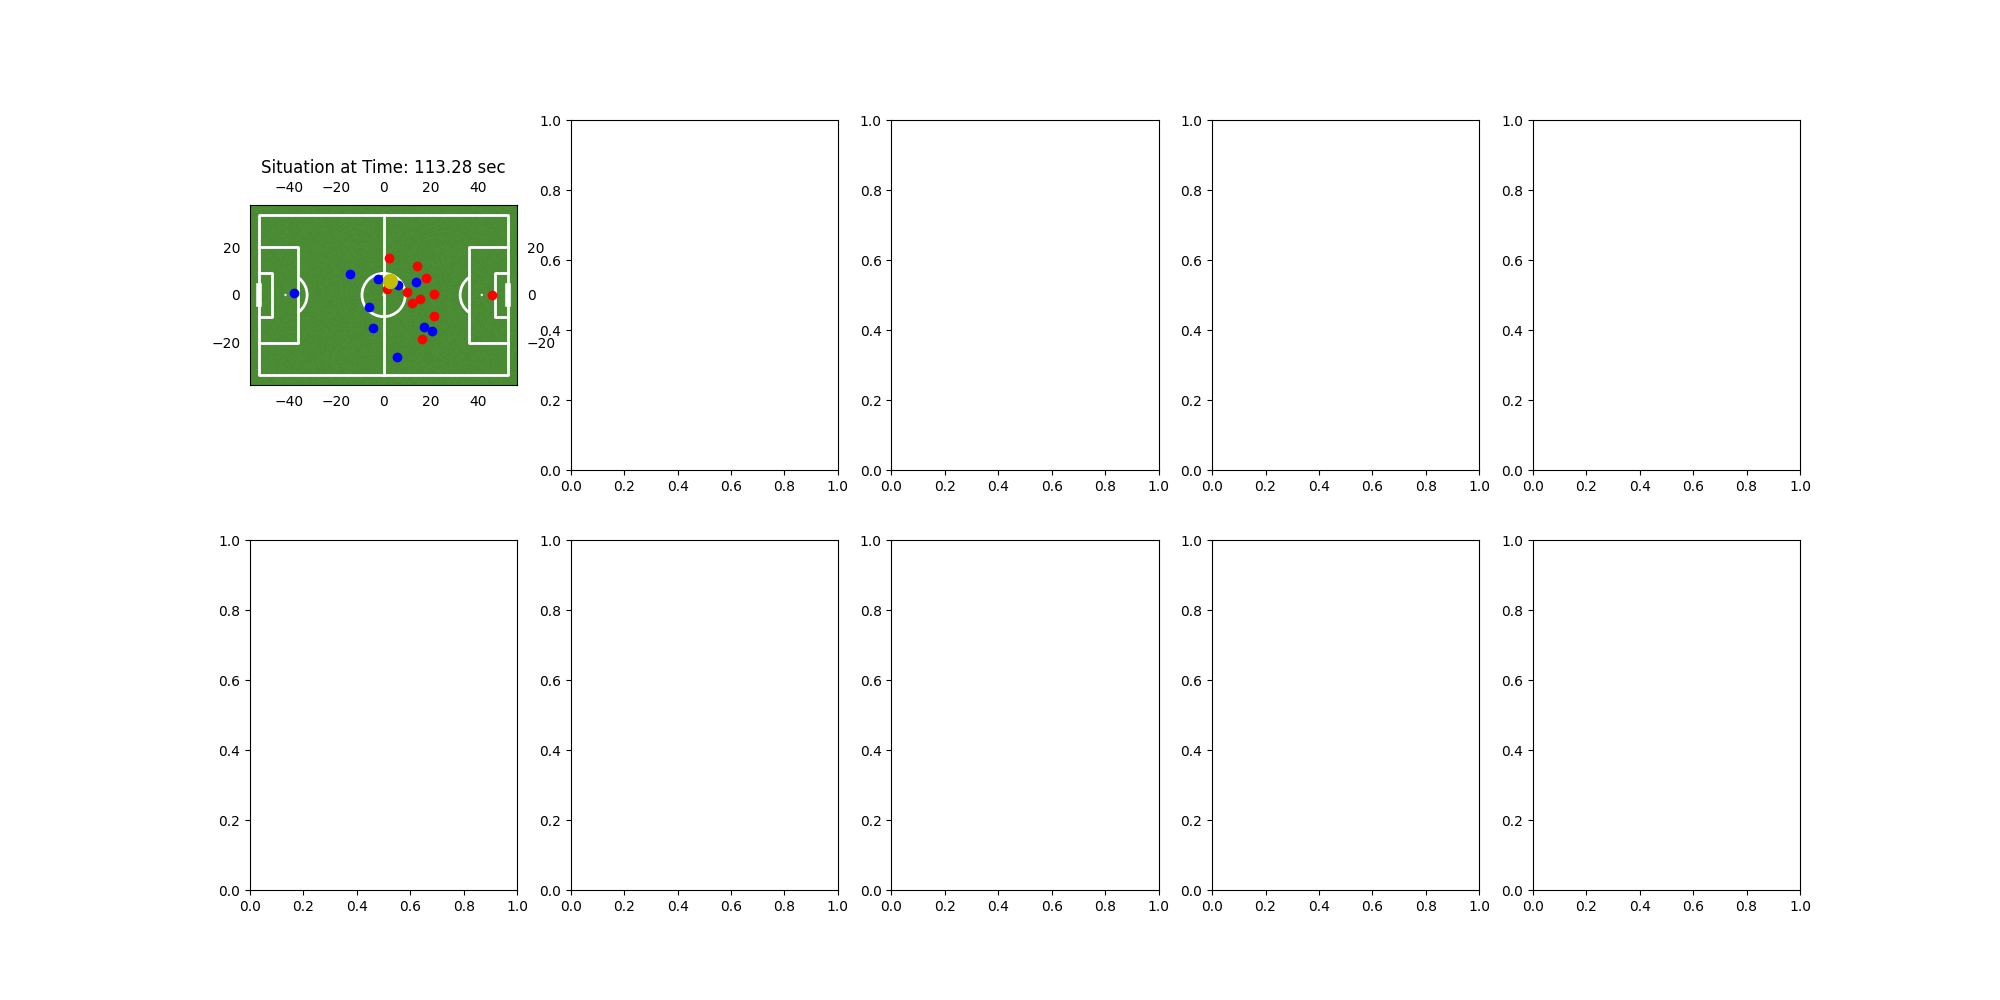

In [69]:
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Flatten positions and extend weights for Wasserstein calculation
def flatten_positions_and_weights(positions, weights):
    positions_array = np.array(positions)  # Ensure positions are in NumPy array format
    flat_positions = positions_array.flatten()  # Flatten x, y positions to a single array
    extended_weights = np.repeat(weights, 2)  # Repeat each weight twice for x and y
    return flat_positions, extended_weights

# Step 1: Extract the player positions for the clicked points
clicked_home_positions, clicked_away_positions = extract_player_positions(one_match.loc[relevant_situations[0]])

# Step 2: Extract the player positions and ball positions for the 10 closest situations
closest_situations_home_positions = []
closest_situations_away_positions = []
closest_situations_ball_positions = []

for situation_index in closest_situations.index:
    home_positions, away_positions = extract_player_positions(closest_situations.loc[situation_index])
    closest_situations_home_positions.append(home_positions)
    closest_situations_away_positions.append(away_positions)
    # Extract the specific ball position for each situation
    ball_x = closest_situations.loc[situation_index, 'ball_x']
    ball_y = closest_situations.loc[situation_index, 'ball_y']
    closest_situations_ball_positions.append((ball_x, ball_y))

# Step 3: Calculate the weights for the clicked points and all of the 10 closest situations
clicked_weights = calculate_weights_from_points(clicked_home_positions, ball_position)

# Calculate weights for the 10 closest situations
closest_situations_weights = []
for i, home_positions in enumerate(closest_situations_home_positions):
    closest_situations_weights.append(calculate_weights_from_points(home_positions, closest_situations_ball_positions[i]))

# Calculate weighted Wasserstein distance between the clicked points and the 10 closest situations
wasserstein_distances = []
clicked_flat_positions, clicked_extended_weights = flatten_positions_and_weights(clicked_home_positions, clicked_weights)

for i, home_positions in enumerate(closest_situations_home_positions):
    situation_flat_positions, situation_extended_weights = flatten_positions_and_weights(home_positions, closest_situations_weights[i])
    distance = wasserstein_distance(clicked_flat_positions, situation_flat_positions, 
                                    u_weights=clicked_extended_weights, v_weights=situation_extended_weights)
    wasserstein_distances.append(distance)

print("Wasserstein distances to closest situations:", wasserstein_distances)

# Step 4: Visualize the 10 closest situations on the pitch with the individual ball positions
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # Create a grid for 10 situations
axes = axes.flatten()

if 'Time [s]' in closest_situations.columns:
    for idx, situation_index in enumerate(closest_situations.index):  # Use the index of the closest situations
        plot_situation(closest_situations.loc[situation_index], axes[idx])  # Pass the row to plot_situation
        ball_pos = closest_situations_ball_positions[idx]  # Get the specific ball position for this situation
        axes[idx].plot(ball_pos[0], ball_pos[1], 'yo', markersize=10, label='Ball')  # Plot the ball position
        axes[idx].set_title(f"Situation at Time: {closest_situations.loc[situation_index, 'Time [s]']:.2f} sec, Wasserstein: {wasserstein_distances[idx]:.2f}")
else:
    print("Ensure that closest_situations contains full rows, including player position columns and time.")

plt.tight_layout()
plt.show()


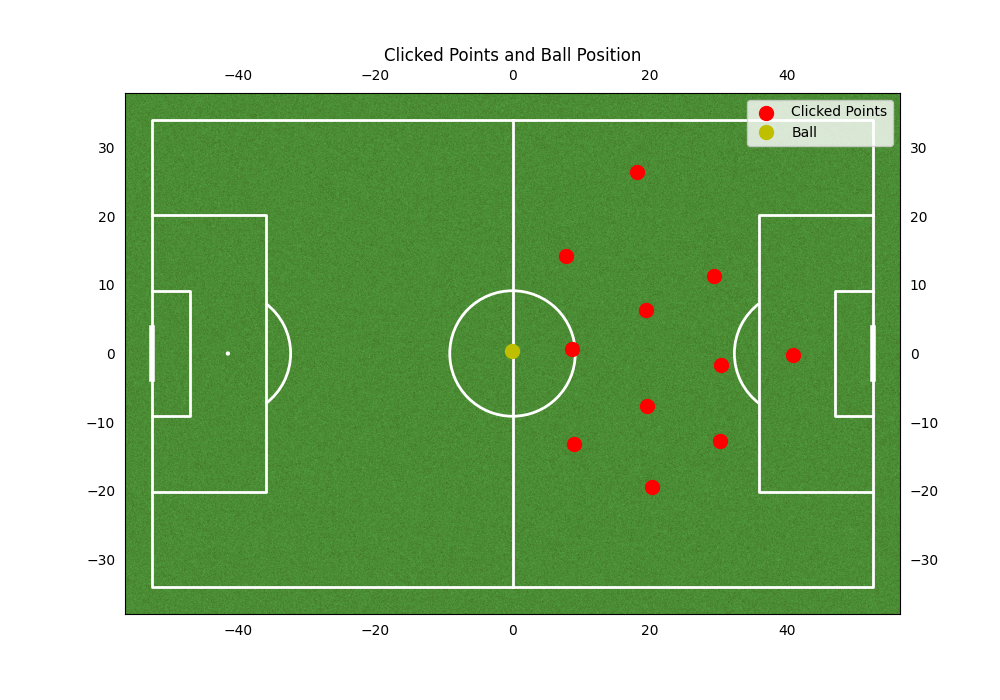

In [66]:
# plot the points_array and the ball position
fig, ax = plt.subplots(figsize=(10, 7))
football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
football_pitch.draw(ax=ax)

# Plot the clicked points
ax.scatter(points_array[:, 0], points_array[:, 1], color='red', label='Clicked Points', s=100)

# Plot the ball position
ax.plot(ball_position[0], ball_position[1], 'yo', markersize=10, label='Ball')

ax.set_title("Clicked Points and Ball Position")
plt.legend()
plt.show()



fig, ax = plt.subplots(figsize=(10, 7))
plot_situation(closest_situations.loc[closest_situations.index[np.argmin(wasserstein_distances)]], ax)
ax.plot(closest_situations_ball_positions[np.argmin(wasserstein_distances)][0], closest_situations_ball_positions[np.argmin(wasserstein_distances)][1], 'yo', markersize=10, label='Ball')  # Plot the ball position
ax.set_title("Most Similar Situation with Ball Position")
plt.show()


In [67]:
import vlc
import time
import tkinter as tk
from tkinter import Button, Label
import numpy as np

# Path to your video file
video_path = "/data/video/EURO2020Russia_vs_Denmark_1st_Half_769630.mp4"

# Video offset in seconds (adjust this value to align video and match time)
video_offset = 52  # Example: If the video starts 2 minutes before the actual match starts

# Create a VLC instance
vlc_instance = vlc.Instance()

# Create a VLC media player
player = vlc_instance.media_player_new()

# Load the media file
media = vlc_instance.media_new(video_path)
player.set_media(media)

# Pause the video initially
player.play()
time.sleep(2)  # Wait for the video to load
player.pause()

# Function to seek to a specific time in seconds
def seek_to_time(player, seconds):
    if isinstance(seconds, (int, float)):  # Ensure that the time is a scalar number
        player.set_time(int((seconds + video_offset) * 1000))  # Add video_offset to align with match time

# Pause the video
def pause_video():
    player.pause()

# Resume the video
def play_video():
    player.play()

# Close the video properly and destroy the tkinter window
def close_video():
    if player.is_playing():
        player.stop()
    player.release()
    root.destroy()  # Close the tkinter window gracefully

# Function to update the current time in the video player
def update_time_label():
    current_time = player.get_time() // 1000  # Get current time in milliseconds, convert to seconds
    time_label.config(text=f"Time: {current_time} seconds")
    root.after(1000, update_time_label)  # Update every second

# Function to skip to the next closest situation time
def next_time():
    global current_index
    if len(closest_situations) > 0:
        current_index = (current_index + 1) % len(closest_situations)
        specific_time_in_seconds = closest_situations.iloc[current_index]['Time [s]']  # Extract the correct time from closest situations
        seek_to_time(player, specific_time_in_seconds)
        time_label.config(text=f"Time: {specific_time_in_seconds} seconds")

# Function to skip to the previous closest situation time
def previous_time():
    global current_index
    if len(closest_situations) > 0:
        current_index = (current_index - 1) % len(closest_situations)
        specific_time_in_seconds = closest_situations.iloc[current_index]['Time [s]']  # Extract the correct time from closest situations
        seek_to_time(player, specific_time_in_seconds)
        time_label.config(text=f"Time: {specific_time_in_seconds} seconds")

# Create the Tkinter window
root = tk.Tk()
root.title("VLC Video Control")

# Pause Button
pause_button = Button(root, text="Pause", command=pause_video)
pause_button.pack(side=tk.LEFT)

# Play Button
play_button = Button(root, text="Play", command=play_video)
play_button.pack(side=tk.LEFT)

# Next Button
next_button = Button(root, text="Next", command=next_time)
next_button.pack(side=tk.LEFT)

# Previous Button
previous_button = Button(root, text="Previous", command=previous_time)
previous_button.pack(side=tk.LEFT)

# Close Button
close_button = Button(root, text="Close", command=close_video)
close_button.pack(side=tk.LEFT)

# Time Label
time_label = Label(root, text="Time: 0 seconds")
time_label.pack(side=tk.LEFT)

# Initialize index for closest situations
current_index = 0

# Ensure closest_situations contains valid data and a 'Time [s]' column
if 'closest_situations' in globals() and not closest_situations.empty:
    
    specific_time_in_seconds = closest_situations.iloc[current_index]['Time [s]']  # Access the first situation's time
    print(f"Initial Time: {specific_time_in_seconds} seconds")
    seek_to_time(player, specific_time_in_seconds)
else:
    print("Error: closest_situations is not properly initialized or is empty.")

# Start updating the time label
update_time_label()

# Keep the video running
root.mainloop()


Initial Time: 113.28 seconds


In [31]:
print(points_array)

[[ 40.93635898  -0.15201617]
 [ 30.29695877 -12.81796879]
 [ 30.4236183   -1.67193048]
 [ 29.41034209  11.24734119]
 [ 18.13764425  26.44648434]
 [ 19.40423952   6.30761967]
 [ 19.65755857  -7.62492822]
 [ 20.2908562  -19.53092368]
 [  9.01815836 -13.19794737]
 [  8.63817979   0.60794099]
 [  7.7515631   14.28716982]]


In [32]:
print(ball_position)

(np.float64(-0.10132752435929149), np.float64(0.35468378075805873))
